# NLP Modeling

Exploratory data analysis suggests that engineered features offer limited value for sentiment classification. Consequently, a Convolutional Neural Network (CNN) model will be developed to directly process tokenized and lemmatized tweet text. This model will predict whether a tweet expresses positive sentiment or not.

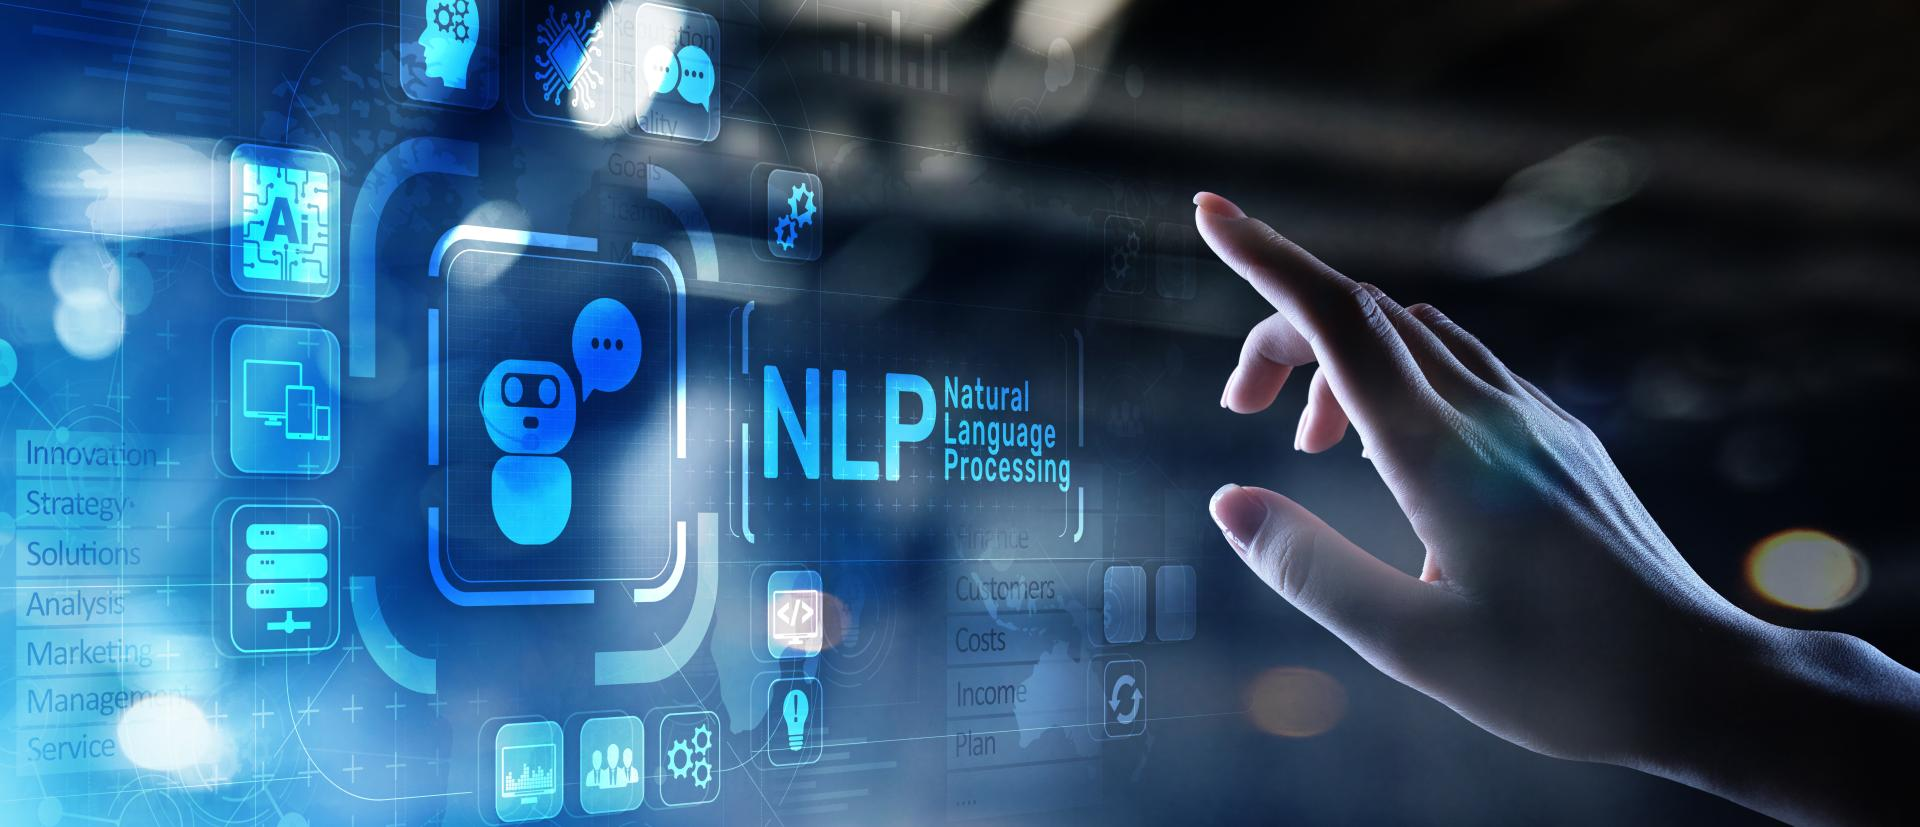

In [111]:
#import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

# import libraries for imbalanced class 
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

In [2]:
#load the dataset
df = pd.read_csv("EDA_tweet_dataset.csv")

In [3]:
df.head()

,tweet,Brand/Product,sentiment,Brand,Hashtags,tweet_Word_Count,Processed_tweet,Original_Sentiment,Token Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Not Positive,Apple,"['#RISE_Austin', '#SXSW']",23,"['have', '3g', 'iphone', '3', 'hr', 'tweeting'...",Negative emotion,13
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,['#SXSW'],22,"['know', 'awesome', 'ipadiphone', 'app', 'like...",Positive emotion,12
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,"['#iPad', '#SXSW']",15,"['can', 'not', 'wait', '2', 'also', 'should', ...",Positive emotion,7
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Not Positive,Apple,['#sxsw'],15,"['hope', 'year', 'festival', 'isnt', 'crashy',...",Negative emotion,8
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,['#SXSW'],17,"['great', 'stuff', 'fri', 'marissa', 'mayer', ...",Positive emotion,14


## Data Preprocessing for Modeling

A  new DataFrame df_model  is created that contains only the columns relevant for NLP modeling: 'Sentiment', 'Processed_Tweet', and 'Token Count'. This helps in focusing on the necessary data and reduces memory usage by excluding irrelevant columns

In [4]:
# Filter the DataFrame to include rows where the 'Brand' is either 'Apple' or 'Google'
df_binary = df[df['Brand'].isin(['Apple', 'Google'])]

# Select the 'sentiment', 'Brand', and 'Processed_tweet' columns
df_binary = df_binary[['sentiment', 'Brand', 'Processed_tweet']]

# Display the first few rows of the filtered DataFrame
df_binary.head()


,sentiment,Brand,Processed_tweet
0,Not Positive,Apple,"['have', '3g', 'iphone', '3', 'hr', 'tweeting'..."
1,Positive,Apple,"['know', 'awesome', 'ipadiphone', 'app', 'like..."
2,Positive,Apple,"['can', 'not', 'wait', '2', 'also', 'should', ..."
3,Not Positive,Apple,"['hope', 'year', 'festival', 'isnt', 'crashy',..."
4,Positive,Google,"['great', 'stuff', 'fri', 'marissa', 'mayer', ..."


In [5]:
# One-hot encode the 'sentiment' column
df_binary['sentiment_encoded'] = df_binary['sentiment'].map({'Not Positive': 0, 'Positive': 1})

# Display the first few rows of the DataFrame with the encoded sentiment column
df_binary.head()

,sentiment,Brand,Processed_tweet,sentiment_encoded
0,Not Positive,Apple,"['have', '3g', 'iphone', '3', 'hr', 'tweeting'...",0
1,Positive,Apple,"['know', 'awesome', 'ipadiphone', 'app', 'like...",1
2,Positive,Apple,"['can', 'not', 'wait', '2', 'also', 'should', ...",1
3,Not Positive,Apple,"['hope', 'year', 'festival', 'isnt', 'crashy',...",0
4,Positive,Google,"['great', 'stuff', 'fri', 'marissa', 'mayer', ...",1


In [6]:
df_binary['sentiment_encoded'].value_counts(normalize= True)

sentiment_encoded
0    0.630596
1    0.369404
Name: proportion, dtype: float64

* we got class imbalance in our dataset so will use SMOTE to increase minority counts

In [7]:
# Define X, y
X = df_binary['Processed_tweet'] # Tweet content is our feature
y = df_binary['sentiment_encoded'] #binary target for negative and positive emotions

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # split data into training and testing

In [8]:
# Instantiate tweet tokenizer to later include in the pipeline
tokenizer = TweetTokenizer()

In [9]:
# Define stop words
stop_lst = stopwords.words('english') + list(string.punctuation) + ['...','#sxsw', '’', '#sxswi', 'sxsw', "''", 'link','rt'] + ['ipad', 'apple', 'google', 'iphone', '#apple', 
                               '#google', '#ipad', '#iphone', 'android'] + [
    'a', 'about', 'after', 'ain', 'all',
    'am', 'an', 'and', 'any', 'as', 'at',
    'be', 'been', 'before', 'being', 'but',
    'by', 'd', 'do', 'does', 'doing',
    'don', 'down', 'during', 'each', 'few',
    'for', 'from', 'further', 'he', 'her',
    'here', 'hers', 'herself', 'him', 'himself',
    'his', 'how', 'i', 'if', 'in', 'into',
    "it's", 'its', 'itself', 'just', 'll', 'm',
    'ma', 'me', 'my', 'myself', 'o', 'of', 'off',
    'on', 'once', 'only', 'or', 'other',
    'our', 'ours', 'ourselves', 'out', 'over',
    'own', 're', 's', 'same', "she's", 'so',
    'some', 'such', 't', 'than', 'that',
    "that'll", 'the', 'their', 'theirs',
    'them', 'themselves', 'then', 'there',
    'these', 'they', 'this', 'those', 'through',
    'to', 'too', 'under', 'until', 'up', 've',
    'we', 'what', 'when', 'where', 'which', 'while',
    'who', 'whom', 'why', 'will', 'with', 'won',
    'y', 'you', "you'd", "you'll", "you're",
    "you've", 'your', 'yours', 'yourself', 'yourselves'
]

# DummyClassifier

## TfidfVectorizer  with DummyClassifier

In [10]:
# # Create the pipeline with DummyClassifier using TfidfVectorizer
dummy_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst, token_pattern=None)),
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Fit the pipeline
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('classifier',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [11]:
# predict target with dummy_pipe on testing set
y_pred = dummy_pipe.predict(X_test)
# print a classification report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1244
           1       0.00      0.00      0.00       750

    accuracy                           0.62      1994
   macro avg       0.31      0.50      0.38      1994
weighted avg       0.39      0.62      0.48      1994



C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [12]:
# check accuracy of the dummy model
accuracy_score(y_test, y_pred)

0.6238716148445336

In [13]:
# Check out confusion matrix
cm1 = confusion_matrix(y_test,y_pred)
cm1

array([[1244,    0],
       [ 750,    0]], dtype=int64)

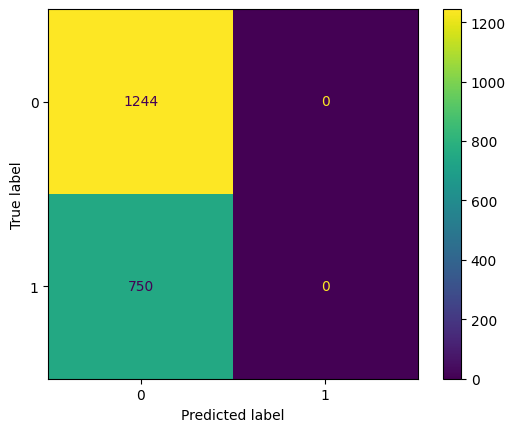

In [14]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

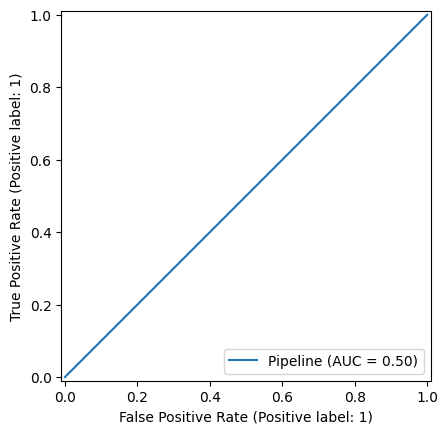

In [15]:
RocCurveDisplay.from_estimator( dummy_pipe, X_test, y_test )

## CountVectorizer with DummyClassifier

In [49]:
# Create the pipeline with DummyClassifier using CountVectorizer
dummy_pipe_count = ImPipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst, token_pattern=None)),
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Fit the pipeline
dummy_pipe_count.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('classifier',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [50]:
# Predict target with dummy_pipe on testing set
y_pred_count = dummy_pipe_count.predict(X_test)

In [51]:
# Print a classification report
print("Count Vectorizer:")
print(classification_report(y_test, y_pred_count))

Count Vectorizer:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1244
           1       0.00      0.00      0.00       750

    accuracy                           0.62      1994
   macro avg       0.31      0.50      0.38      1994
weighted avg       0.39      0.62      0.48      1994



C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\learn-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [52]:
# Check accuracy of the dummy model
print("Accuracy:", accuracy_score(y_test, y_pred_count))

Accuracy: 0.6238716148445336


In [53]:
# Check out confusion matrix
cm_count = confusion_matrix(y_test, y_pred_count)
print("Confusion Matrix:\n", cm_count)

Confusion Matrix:
 [[1244    0]
 [ 750    0]]


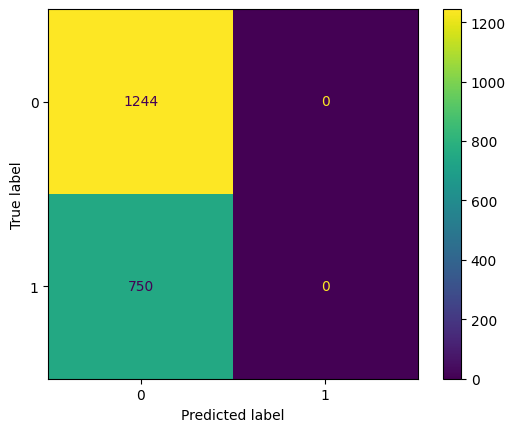

In [54]:
# Plot confusion matrix
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count)
disp_count.plot()
plt.show()

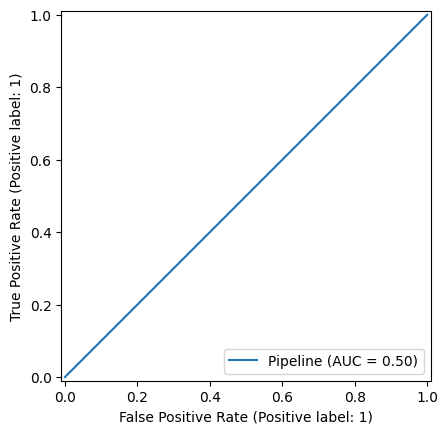

In [55]:
# Plot ROC curve
RocCurveDisplay.from_estimator(dummy_pipe_count, X_test, y_test)
plt.show()

* Both baseline DummyClassifier using CountVectorizer and TfidfVectorizer model achieved a poor accuracy of 0.62 and an AUC score of 0.5, indicating minimal predictive power. The performance of a Random Forest model using identical preprocessing steps will be evaluated next

# Random Forest  Model

## TfidfVectorizer with Random Forest:

In [16]:
# Create the pipeline for Random Forest with CountVectorizer
rfc_pipe = ImPipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stop_lst ,token_pattern=None)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('smote', SMOTE(sampling_strategy = 1, random_state = 42)), # use SMOTE to get 1:1 ratio for both classes
                     ('rfc', RandomForestClassifier(random_state=42))]) # first attempt: Random forest classifier

rfc_pipe.fit(X_train, y_train) 

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [17]:
y_pred = rfc_pipe.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1244
           1       0.64      0.54      0.58       750

    accuracy                           0.71      1994
   macro avg       0.69      0.68      0.68      1994
weighted avg       0.70      0.71      0.71      1994



In [18]:
accuracy_score(y_test, y_pred)

0.7111334002006018

In [19]:
recall_score(y_test, y_pred)

0.5373333333333333

In [20]:
cm2 = confusion_matrix(y_test,y_pred)
cm2

array([[1015,  229],
       [ 347,  403]], dtype=int64)

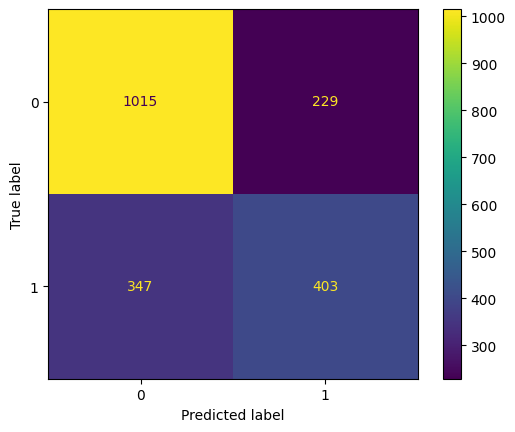

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

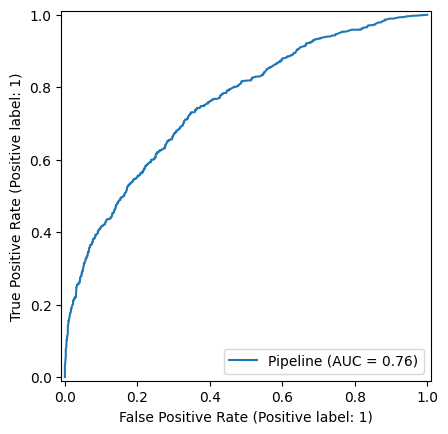

In [22]:
RocCurveDisplay.from_estimator( rfc_pipe, X_test, y_test )

## CountVectorizer with Random Forest:

In [56]:
# Create the pipeline for Random Forest with CountVectorizer
rfc_pipe_count = ImPipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst, token_pattern=None)),
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])
# Fit the pipeline
rfc_pipe_count.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [57]:
# Predict target with rfc_pipe on testing set
y_pred_count = rfc_pipe_count.predict(X_test)

In [58]:
# Print a classification report
print("Count Vectorizer:")
print(classification_report(y_test, y_pred_count))

Count Vectorizer:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1244
           1       0.51      0.65      0.57       750

    accuracy                           0.64      1994
   macro avg       0.63      0.64      0.63      1994
weighted avg       0.66      0.64      0.64      1994



In [59]:
# Check accuracy of the model
print("Accuracy:", accuracy_score(y_test, y_pred_count))

Accuracy: 0.6354062186559679


In [60]:
# Check recall of the model
print("Recall:", recall_score(y_test, y_pred_count))


Recall: 0.6533333333333333


In [61]:
# Check out confusion matrix
cm_countRF = confusion_matrix(y_test, y_pred_count)
print("Confusion Matrix:\n", cm_countRF)

Confusion Matrix:
 [[777 467]
 [260 490]]


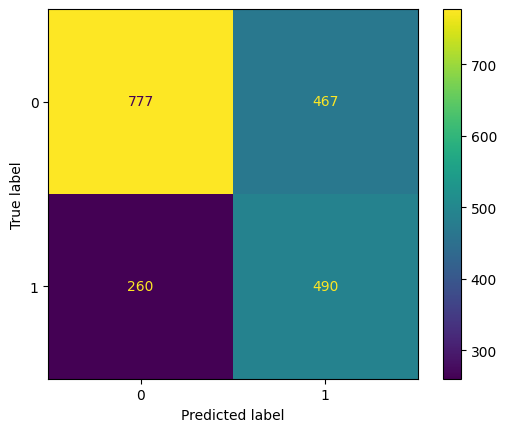

In [62]:
# Plot confusion matrix
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_countRF)
disp_count.plot()
plt.show()

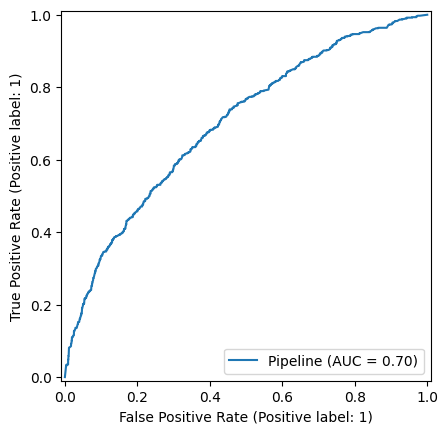

In [63]:
# Plot ROC curve
RocCurveDisplay.from_estimator(rfc_pipe_count, X_test, y_test)
plt.show()

## Combined Features with Random Forest

In [68]:
# Define the vectorizers
tfidf_vectorizer = ('tfidf', TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst, token_pattern=None))
count_vectorizer = ('count', CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_lst, token_pattern=None))

# Combine the vectorizers using FeatureUnion
combined_features = FeatureUnion([tfidf_vectorizer, count_vectorizer])

# Create a pipeline with the combined features, SMOTE, and Naive Bayes classifier
nb_pipe = ImPipeline([
    ('features', combined_features),
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('nb', MultinomialNB())
])

# Fit the pipeline to the training data
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(stop_words=['i',
                                                                             'me',
                                                                             'my',
                                                                             'myself',
                                                                             'we',
                                                                             'our',
                                                                             'ours',
                                                                             'ourselves',
                                                                             'you',
                                                                             "you're",
                                                                             "you've",
                                                                             "you'll",
                                                                             "you'd",
                                                                             'your',
                                                                             'yours',
                                                                             'yourself',
                                                                             'yourselves',
                                                                             'he',
                                                                             'him',
                                                                             'his',
                                                                             'himself',
                                                                             'she',
                                                                             "she's",
                                                                             'her',
                                                                             'hers',
                                                                             'herself',
                                                                             'it',
                                                                             "it's",
                                                                             'its',
                                                                             'itself', ...],
                                                                 token_pattern=None,
                                                                 tokeni...
                                                                             "you'd",
                                                                             'your',
                                                                             'yours',
                                                                             'yourself',
                                                                             'yourselves',
                                                                             'he',
                                                                             'him',
                                                                             'his',
                                                                             'himself',
                                                                             'she',
                                                                             "she's",
                                                                             'her',
                                                                             'hers',
                                                                    

In [69]:
# Make predictions
y_pred = nb_pipe.predict(X_test)

In [70]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.72      1244
           1       0.55      0.69      0.61       750

    accuracy                           0.67      1994
   macro avg       0.67      0.68      0.66      1994
weighted avg       0.69      0.67      0.68      1994



In [71]:
# Print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.6720160481444333


In [72]:
# Print recall score
print("Recall Score:", recall_score(y_test, y_pred, average='macro'))

Recall Score: 0.6751897106109325


In [73]:
# Compute and print confusion matrix
cm_RF_reunion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm_RF_reunion )

Confusion Matrix:
 [[824 420]
 [234 516]]


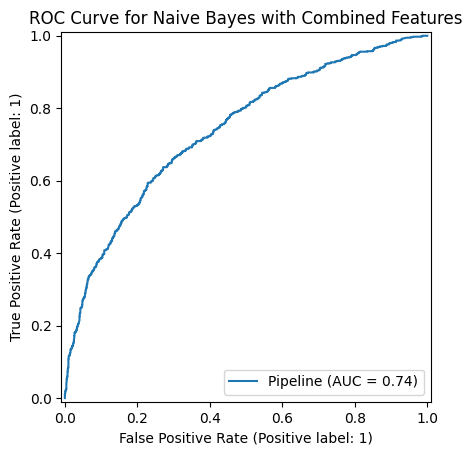

In [74]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(nb_pipe, X_test, y_test)
plt.title('ROC Curve for Naive Bayes with Combined Features')
plt.show()

* Combined Features seems to be the best approach. It provides a balance between precision and recall for both classes and achieves a reasonable accuracy. This approach leverages the strengths of both TfidfVectorizer and CountVectorizer, resulting in a more robust model.

* Comparing this  random forest  model with combined features  with dummy model, this one performs much better with an accuracy of 0.67 and an AUC score of 0.74

# Perform GridSearch on random forest

In [75]:
# Create the pipeline with the combined features, SMOTE, and RandomForestClassifier
rfc_pipe = ImPipeline([
    ('features', combined_features),
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])
# Define the parameter grid for GridSearchCV
param_grid = {
    'rfc__n_estimators': [100, 200],
    'rfc__max_depth': [10, 20, None],
    'rfc__min_samples_split': [2, 5],
    'rfc__min_samples_leaf': [1, 2],
    'rfc__criterion': ['gini', 'entropy']
}

In [76]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rfc_pipe, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('tfidf',
                                                                        TfidfVectorizer(stop_words=['i',
                                                                                                    'me',
                                                                                                    'my',
                                                                                                    'myself',
                                                                                                    'we',
                                                                                                    'our',
                                                                                                    'ours',
                                                                                                    'ourselves',
                                                                                                    'you',
                                                                                                    "you're",
                                                                                                    "you've",
                                                                                                    "you'll",
                                                                                                    "you'd",
                                                                                                    'your',
                                                                                                    'yours',
                                                                                                    'yourself',
                                                                                                    'yourselves',
                                                                                                    'he',
                                                                                                    'him',
                                                                                                    'his',
                                                                                                    'himself',
                                                                                                    'she',
                                                                                                    "she's",
                                                                                                    'her',
                                                                                                    'hers',
                                                                                                    'herself',
                                                                                                    'it',
                                                                                                    "it's",
                                                                                                    'its',
                                                                                                    'itself', .....
                                                                                        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>))])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rfc__criterio

In [77]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 200}


In [112]:
# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_rfc_model.pkl')


['best_rfc_model.pkl']

In [78]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [79]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78      1244
           1       0.65      0.52      0.57       750

    accuracy                           0.71      1994
   macro avg       0.69      0.67      0.68      1994
weighted avg       0.71      0.71      0.70      1994



In [80]:
# Print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.7126379137412236


In [81]:
# Print recall score
print("Recall Score:", recall_score(y_test, y_pred, average='macro'))

Recall Score: 0.6735948553054663


In [83]:
# Compute and print confusion matrix
cm_RF_gridsearch = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm_RF_gridsearch)

Confusion Matrix:
 [[1034  210]
 [ 363  387]]


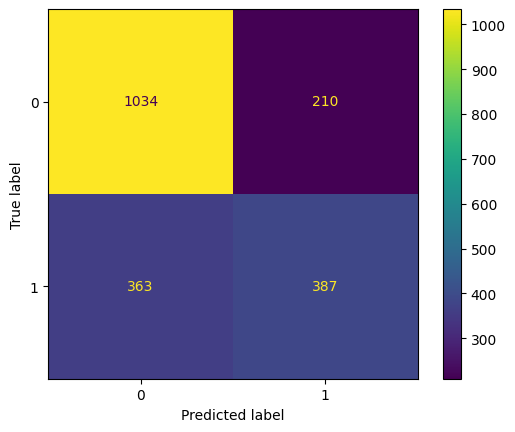

In [84]:
# Plot confusion matrix
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_RF_gridsearch)
disp_count.plot()
plt.show()

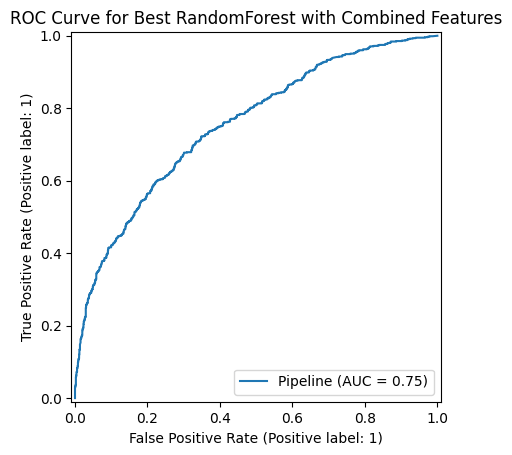

In [82]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve for Best RandomForest with Combined Features')
plt.show()

* The overall accuracy of the model is 71%, indicating that 71% of the tweets were correctly classified.

* The model correctly identified 83% of the negative sentiment tweets, meaning it has a strong ability to detect negative tweets
* The model correctly identified only 52% of the positive sentiment tweets, meaning it misses almost half of the positive tweets.

# 1st logistic regression model

## logistic regression model with TfidfVectorizer

In [32]:
# Create a pipeline for logistic regression model with TfidfVectorizer
logreg_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst,token_pattern=None)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42))
])

logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr', LogisticRegression(random_state=42))])

In [33]:
y_pred = logreg_pipe.predict(X_test)

In [34]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1244
           1       0.59      0.63      0.61       750

    accuracy                           0.70      1994
   macro avg       0.68      0.68      0.68      1994
weighted avg       0.70      0.70      0.70      1994



In [35]:
accuracy_score(y_test, y_pred)

0.6965897693079238

In [36]:
recall_score(y_test, y_pred)

0.628

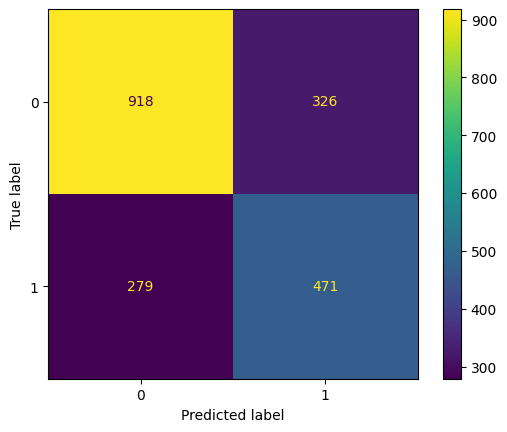

In [37]:
cm4 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp.plot()
plt.show()

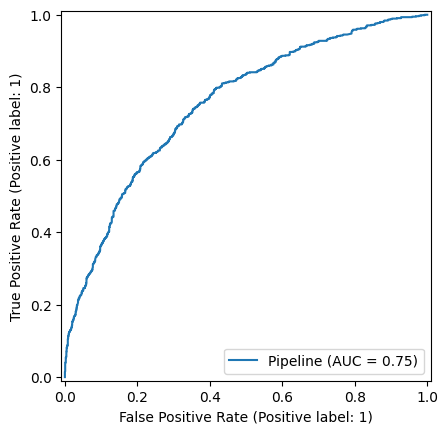

In [38]:
RocCurveDisplay.from_estimator(logreg_pipe , X_test, y_test )

## logistic regression model with CountVectorizer

In [86]:
# Create a pipeline for logistic regression model with CountVectorizer
logreg_pipe_count = ImPipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst, token_pattern=None)), 
    ('smote', SMOTE(sampling_strategy=1, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
logreg_pipe_count.fit(X_train, y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr', LogisticRegression(random_state=42))])

In [87]:
# Predict the test data
y_pred_count = logreg_pipe_count.predict(X_test)


In [88]:
# Print the classification report
print("Classification Report with CountVectorizer:\n", classification_report(y_test, y_pred_count))


Classification Report with CountVectorizer:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      1244
           1       0.54      0.62      0.58       750

    accuracy                           0.66      1994
   macro avg       0.65      0.65      0.65      1994
weighted avg       0.67      0.66      0.66      1994



In [89]:
# Print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred_count))

Accuracy Score: 0.6589769307923772


In [90]:
# Print recall score
print("Recall Score:", recall_score(y_test, y_pred_count, average='macro'))

Recall Score: 0.6520321543408361


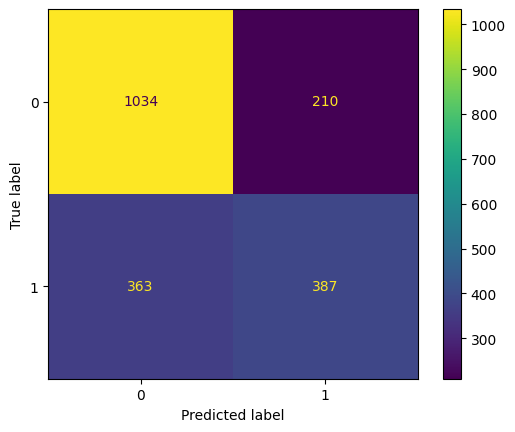

In [92]:
cm4_count = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4_count)
disp.plot()
plt.show()

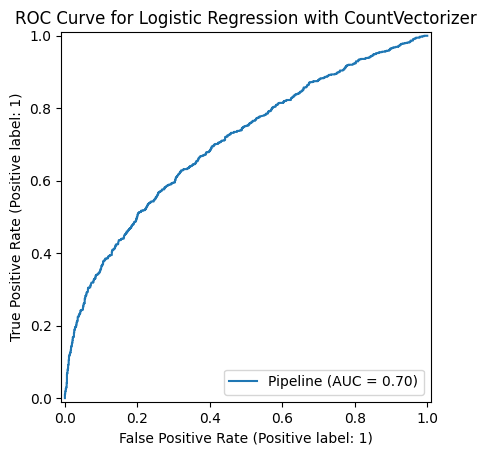

In [93]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg_pipe_count, X_test, y_test)
plt.title('ROC Curve for Logistic Regression with CountVectorizer')
plt.show()

* TfidfVectorizer is the better choice in this scenario as it demonstrates higher accuracy, better precision, recall, and F1-score for both classes. The overall macro and weighted averages also favor the TfidfVectorizer, indicating that it provides better performance for the logistic regression model on this dataset.

## Perform GridSearch on Logistic Regression

In [94]:
params = {}
params['lr__class_weight'] = ['balanced']
params['lr__max_iter'] = [100, 200, 300, 500, 700,1000]
params['lr__C'] = [0.01, 0.1, 1]
params['lr__solver']: ['liblinear', 'lbfgs', 'sag','saga', 'newton-cholesky']



gs_logreg = GridSearchCV(estimator=logreg_pipe, 
                              param_grid = params, 
                              scoring='accuracy')

In [95]:
gs_logreg.fit(X_train,  y_train)
gs_logreg.best_params_

{'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100}

In [96]:
# 'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 100
# Create a pipeline for a best tuned logistic regression model
logreg_best_pipe = ImPipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stop_lst,token_pattern=None)), 
    ('smote', SMOTE(sampling_strategy = 1, random_state = 42)),
    ('lr', LogisticRegression(random_state=42,
                             C = 1,
                             class_weight = 'balanced',
                             max_iter = 100))
])

logreg_best_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x0000016412A47CB0>>)),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('lr',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42))])

In [97]:
y_pred = logreg_best_pipe.predict(X_test)

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1244
           1       0.59      0.63      0.61       750

    accuracy                           0.70      1994
   macro avg       0.68      0.68      0.68      1994
weighted avg       0.70      0.70      0.70      1994



In [99]:
accuracy_score(y_test, y_pred)

0.6965897693079238

In [100]:
recall_score(y_test, y_pred)

0.628

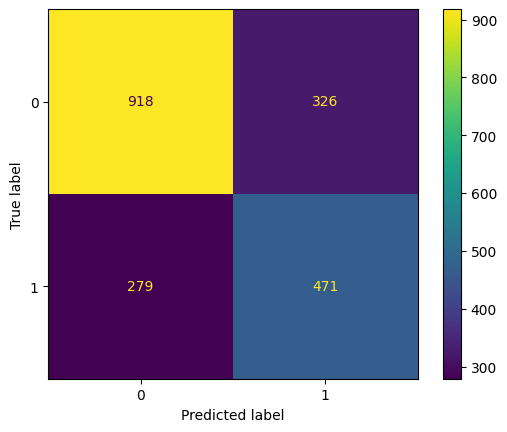

In [101]:
cm5 = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp.plot()
plt.show()

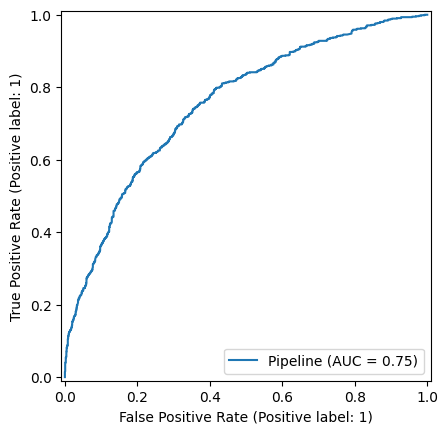

In [102]:
RocCurveDisplay.from_estimator(logreg_best_pipe , X_test, y_test )

## Modeling Conclusion: random forest model with combined features  has the best results. With an Accuracy: 0.71 Recall for Class 0: 0.83 ,AUC Score: 75

* Based on the analysis, the model with Combined Features, SMOTE, and RandomForestClassifier generally performs the best, especially in terms of accuracy, precision, and recall for negative sentiment (Class 0). It also ties with the Tuned Logistic Regression in several other metrics, including AUC.

* Given our goal of extracting useful information from tweets on Apple and Google products and exploring the emotion distribution, the Pipeline with Combined Features, SMOTE, and RandomForestClassifier is the best model to use for your project. It provides a good balance of precision, recall, and overall accuracy, making it suitable for analyzing sentiment in tweets.

## Model Use Examples

Below is an example of how the model may be used, a series of tweets are input and their sentiment is predicted.

In [113]:
# Load the saved model (optional, to demonstrate loading)
best_model = joblib.load('best_rfc_model.pkl')

In [114]:
# Predict on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78      1244
           1       0.65      0.52      0.57       750

    accuracy                           0.71      1994
   macro avg       0.69      0.67      0.68      1994
weighted avg       0.71      0.71      0.70      1994



In [115]:
# Predict on new example tweets
test_tweets = ["I love Oranges!", "I did not like this", "My favorite color is green"]
input_pred_label = best_model.predict(test_tweets)


In [116]:
# Display predictions
for i in range(len(test_tweets)):
    if input_pred_label[i] == 1:
        print(f"The Tweet [{test_tweets[i]}] is Positive")
    elif input_pred_label[i] == 0:
        print(f"The Tweet [{test_tweets[i]}] is Not Positive")

The Tweet [I love Oranges!] is Positive
The Tweet [I did not like this] is Not Positive
The Tweet [My favorite color is green] is Not Positive


# Adaptation and Utilization of the Model for Apple and Google

## For Apple:

### Product Feedback:

- **Positive Tweets:** Focus on aspects like iPad2, iPhone, and Apple Store, especially noting mentions of "amazing" and "free products."
- **Negative Tweets:** Address issues related to applications, physical stores, and battery life. Mentions of "bad," "fail," "fascist," and long wait times at stores indicate specific pain points.

### Customer Interaction:

- **Positive Sentiment:** Highlight customer experiences with promotional giveaways and the opening of new retail locations.
- **Negative Sentiment:** Improve customer service at physical stores to reduce wait times. Address battery life concerns and enhance product design to avoid criticisms.

## For Google:

### Product Feedback:

- **Positive Tweets:** Highlight features of Google Maps, social network launches, and positive mentions of company events or leaders (e.g., Marissa Mayer).
- **Negative Tweets:** Address issues with the mapping product, and any controversies surrounding product launches, indicated by terms like "suck," "lost," and "deadly."

### Customer Interaction:

- **Positive Sentiment:** Promote successful events and product launches, emphasizing user engagement and satisfaction.
- **Negative Sentiment:** Improve the functionality of products like Google Maps and address any issues related to product launches.

## Findings from Wordcloud Visualization

### Apple:

- **Positive Sentiment:** iPad2, iPhone, Apple Store, amazing, free.
- **Negative Sentiment:** Applications, physical stores, battery life, fascist, bad, fail, long wait times, business practices, product design.

### Google:

- **Positive Sentiment:** Map, circle, party, launch, social network, new, mobile, Marissa Mayer, free.
- **Negative Sentiment:** Social, circle, launch, bing, network, suck, lost, deadly, mapping product.

## Recommendations

### For Apple:

1. **Address Battery Life Issues:** Prioritize enhancements in battery technology and customer education on battery management.
2. **Improve Store Experience:** Reduce wait times and enhance customer service.
3. **Promote Positive Experiences:** Continue with promotional giveaways and leverage positive feedback in marketing campaigns.
4. **Respond to Criticisms:** Be proactive in addressing criticisms about business practices and product design.

### For Google:

1. **Enhance Product Functionality:** Focus on improving the mapping product and resolving any issues with new product launches.
2. **Leverage Positive Feedback:** Use successful events and launches to strengthen marketing and customer engagement strategies.
3. **Address Negative Sentiment:** Actively respond to criticisms and controversies to maintain customer trust and satisfaction.

## Words Leading to Sentiment Classification

### Positive Words:

- **Apple:** iPad2, iPhone, Apple Store, amazing, free.
- **Google:** Map, circle, party, launch, social network, new, mobile, Marissa Mayer, free.

### Negative Words:

- **Apple:** Fascist, bad, fail, battery life, long wait times, business practices, product design.
- **Google:** Suck, lost, deadly, social, circle, bing, network, mapping product.

## Future Work

### Model Improvement:

1. **Hyperparameter Tuning:** Further refine models through hyperparameter tuning.
2. **Ensemble Methods:** Explore ensemble methods to improve prediction accuracy.
3. **Deep Learning Models:** Implement deep learning models like RNNs or BERT for better understanding of context.

### Data Expansion:

1. **Additional Data Sources:** Incorporate data from other social media platforms and review sites.
2. **Larger Dataset:** Expand the dataset to include more tweets for more robust analysis.

### Real-Time Analysis:

1. **Stream Processing:** Implement real-time data streaming to provide up-to-date sentiment analysis.
2. **Dashboard Development:** Create dashboards for Apple and Google to monitor sentiment trends and customer feedback in real-time.

### Customized Analysis:

1. **Product-Specific Models:** Develop separate models for different products to gain more granular insights.
2. **Regional Analysis:** Conduct regional sentiment analysis to understand geographical variations in customer feedback.

By leveraging these findings and recommendations, Apple and Google can enhance their customer service, improve product offerings, and better understand their customers' sentiments, ultimately leading to increased customer satisfaction and loyalty.
